# Postverdad — Entities Pack **C: Perfil** (sin vistas)
Incluye:
- **(9) Perfil de entidad**: card con volumen, fuentes principales, polarity (neg/neu/pos y promedio), subjectivity (media y cuantiles), co-ocurrencias top y línea temporal.
- **(1) Top Entities (reducido)**: top por volumen y cuota en el periodo.
- **(2) Tendencias (reducido)**: serie por las entidades seleccionadas (o top-N si no defines una lista).

**Uso**
1. Ajusta los **parámetros** (fechas, tipos, medios, entidades objetivo).
2. Ejecuta todas las celdas.
3. Repite con otros parámetros si necesitas.

> Consulta directa a `articles`, `entities`, `articles_entities`, `sources` (no depende de vistas).


In [1]:
import os
import pandas as pd
import numpy as np
import psycopg2
from psycopg2.extras import RealDictCursor
import matplotlib.pyplot as plt
from itertools import combinations

pd.set_option('display.max_rows', 20)

# Credenciales desde variables de entorno
PG = {
    "host": os.getenv("POSTGRES_HOST", "localhost"),
    "port": int(os.getenv("POSTGRES_PORT", "5432")),
    "dbname": os.getenv("POSTGRES_DB", "postverdad"),
    "user": os.getenv("POSTGRES_USER", "postverdad"),
    "password": os.getenv("POSTGRES_PASSWORD", "postverdad"),
}
PG

{'host': 'localhost',
 'port': 5432,
 'dbname': 'postverdad',
 'user': 'postverdad',
 'password': 'postverdad'}

## Parámetros

In [2]:
# Fechas (ISO YYYY-MM-DD)
END_DATE = pd.Timestamp.utcnow().date().isoformat()
START_DATE = (pd.Timestamp(END_DATE) - pd.Timedelta(days=90)).date().isoformat()

# Tipos de entidad (['PER','ORG','LOC'] o [] para todos)
ENTITY_TYPES = ['PER','ORG','LOC']

# Medios (lista de names en sources.name) o [] para todos
SOURCES = []

# Entidades objetivo (por nombre). Si vacío, se tomarán las top por volumen.
TARGET_ENTITIES = []   # p.ej.: ['Gabriel Boric', 'Ministerio de Salud']

# Config Perfil
TOP_SOURCES = 10       # fuentes a mostrar por entidad
TOP_COOCC = 20         # co-ocurrencias top por entidad
TREND_FREQ = 'D'       # 'D' diario | 'W' semanal

# Reducidos
TOP_ENTITIES_REDUCED = 20
TOP_TREND_ENTITIES = 5

START_DATE, END_DATE, ENTITY_TYPES, SOURCES, TARGET_ENTITIES, TREND_FREQ

('2025-06-07', '2025-09-05', ['PER', 'ORG', 'LOC'], [], [], 'D')

In [3]:
def read_sql_df(query, params=None):
    conn = psycopg2.connect(**PG)
    try:
        with conn.cursor(cursor_factory=RealDictCursor) as cur:
            cur.execute(query, params or {})
            rows = cur.fetchall()
        return pd.DataFrame(rows)
    finally:
        conn.close()

## Carga base (articles × entities)

In [4]:
def fetch_article_entities(start_date, end_date, entity_types=None, sources=None):
    entity_types = entity_types or []
    sources = sources or []
    sql = '''
        SELECT
          a.id   AS article_id,
          a.publication_date,
          a.polarity,
          a.subjectivity,
          s.name AS source,
          e.id   AS entity_id,
          e.name AS entity_name,
          e.type AS entity_type
        FROM articles a
        JOIN articles_entities ae ON ae.article_id = a.id
        JOIN entities e ON e.id = ae.entity_id
        LEFT JOIN sources s ON s.id = a.source_id
        WHERE a.publication_date >= %(start)s
          AND a.publication_date < (%(end)s::date + INTERVAL '1 day')
    '''
    params = {'start': start_date, 'end': end_date}
    if entity_types:
        sql += " AND e.type = ANY(%(types)s)"
        params['types'] = entity_types
    if sources:
        sql += " AND s.name = ANY(%(sources)s)"
        params['sources'] = sources
    sql += " ORDER BY a.publication_date DESC NULLS LAST"
    df = read_sql_df(sql, params)
    if not df.empty:
        df['publication_date'] = pd.to_datetime(df['publication_date'], errors='coerce')
    return df

df = fetch_article_entities(START_DATE, END_DATE, ENTITY_TYPES, SOURCES)
print(f"Filas cargadas: {len(df)}")
df.head(10)

Filas cargadas: 81726


,article_id,publication_date,polarity,subjectivity,source,entity_id,entity_name,entity_type
0,6267,2025-09-05,0.0,0.0928,el_mostrador,13274,Reuters,ORG
1,6258,2025-09-05,0.0,0.0805,el_mostrador,89671,Prevost,PER
2,6258,2025-09-05,0.0,0.0805,el_mostrador,88916,Astroza,ORG
3,6258,2025-09-05,0.0,0.0805,el_mostrador,88914,Paulina Astroza,PER
4,6258,2025-09-05,0.0,0.0805,el_mostrador,88913,Centro de Estudios Europeos de la Universidad ...,ORG
5,6258,2025-09-05,0.0,0.0805,el_mostrador,88912,Ciencias Políticas y Sociales,ORG
6,6258,2025-09-05,0.0,0.0805,el_mostrador,73667,Plaza de San Pedro,LOC
7,6258,2025-09-05,0.0,0.0805,el_mostrador,71524,Jesucristo,PER
8,6258,2025-09-05,0.0,0.0805,el_mostrador,60004,Grande,PER
9,6258,2025-09-05,0.0,0.0805,el_mostrador,55327,León XIII,PER


### (Opcional) Deduplicación por (artículo, entidad)

In [5]:
# df = df.drop_duplicates(subset=['article_id','entity_id'])

## (1 reducido) Top Entities del periodo

In [6]:
def top_entities(df, top_n=20):
    if df.empty:
        return pd.DataFrame(columns=['entity_name','entity_type','n','share_pct'])
    counts = (df.groupby(['entity_name','entity_type'])
                .size()
                .rename('n')
                .reset_index()
                .sort_values('n', ascending=False))
    total = counts['n'].sum()
    counts['share_pct'] = (100.0 * counts['n'] / max(total, 1)).round(2)
    return counts.head(top_n)

top_df = top_entities(df, TOP_ENTITIES_REDUCED)
top_df.head(20)

,entity_name,entity_type,n,share_pct
5891,Chile,LOC,1830,2.24
10408,El Mostrador,ORG,687,0.84
28335,Santiago,LOC,457,0.56
11269,Estado,LOC,453,0.55
11385,Estados Unidos,LOC,443,0.54
16814,Jeannette Jara,PER,363,0.44
13416,Gabriel Boric,PER,334,0.41
13963,Gobierno,LOC,316,0.39
11599,Evelyn Matthei,PER,295,0.36
17355,José Antonio Kast,PER,271,0.33


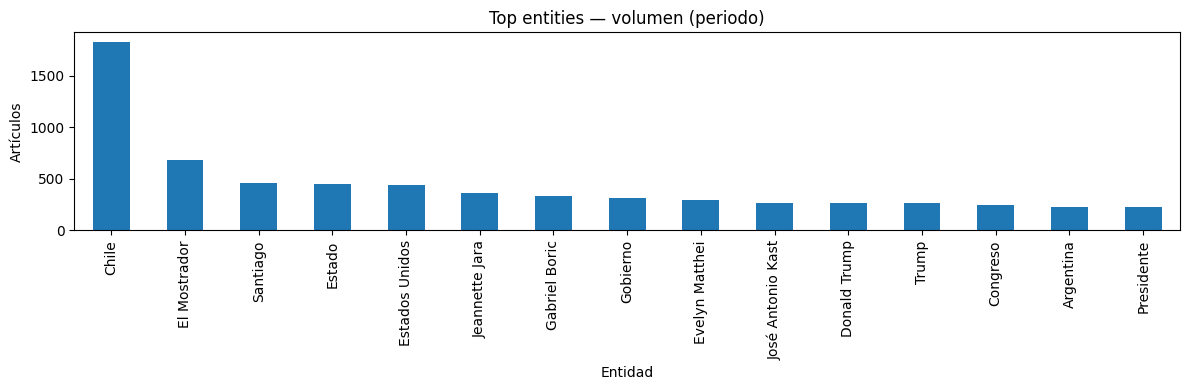

In [7]:
# Gráfico rápido (top 15)
if not top_df.empty:
    ax = top_df.set_index('entity_name')['n'].head(15).plot(kind='bar', figsize=(12,4))
    ax.set_title('Top entities — volumen (periodo)')
    ax.set_xlabel('Entidad')
    ax.set_ylabel('Artículos')
    plt.tight_layout()
    plt.show()

## Selección de entidades objetivo

In [8]:
if not TARGET_ENTITIES:
    TARGET_ENTITIES = top_df['entity_name'].head(TOP_TREND_ENTITIES).tolist()
TARGET_ENTITIES

['Chile', 'El Mostrador', 'Santiago', 'Estado', 'Estados Unidos']

## (2 reducido) Tendencias para entidades objetivo

In [9]:
def trends_for_targets(df, targets, freq='D'):
    if df.empty or not targets:
        return pd.DataFrame()
    d = df[df['entity_name'].isin(targets)].copy()
    d['period'] = d['publication_date'].dt.to_period(freq).dt.to_timestamp()
    ts = (d.groupby(['entity_name','period'])
            .size()
            .rename('n')
            .reset_index()
            .sort_values('period'))
    return ts

trends = trends_for_targets(df, TARGET_ENTITIES, TREND_FREQ)
trends.head(10)

,entity_name,period,n
0,Chile,2025-06-07,19
236,Estados Unidos,2025-06-07,6
314,Santiago,2025-06-07,3
79,El Mostrador,2025-06-07,3
1,Chile,2025-06-08,23
237,Estados Unidos,2025-06-08,7
158,Estado,2025-06-08,8
315,Santiago,2025-06-08,4
80,El Mostrador,2025-06-08,12
2,Chile,2025-06-13,26


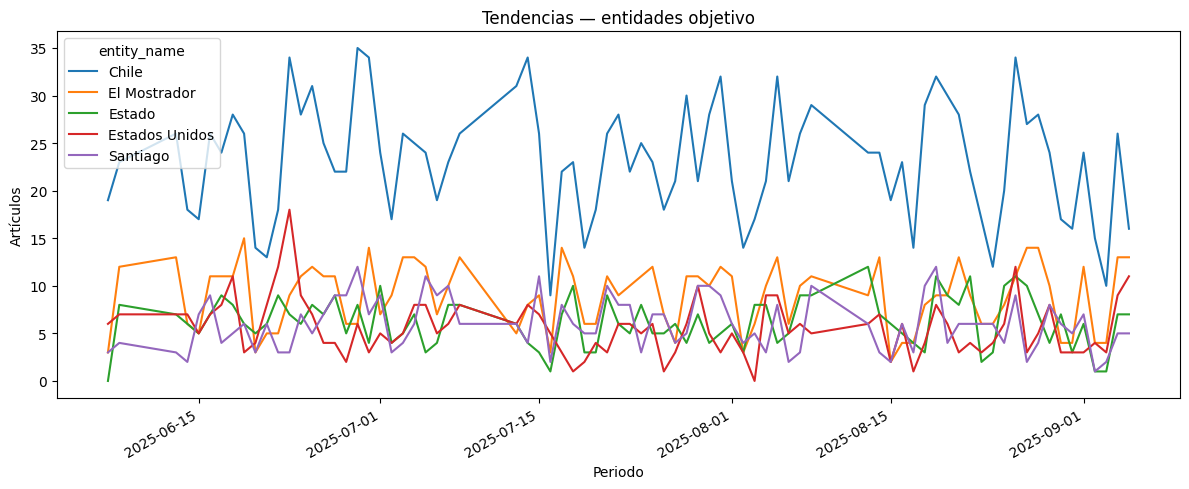

In [10]:
# Gráfico: una línea por entidad (mismo eje)
if not trends.empty:
    pivot_ts = trends.pivot(index='period', columns='entity_name', values='n').fillna(0)
    ax = pivot_ts.plot(figsize=(12,5))
    ax.set_title('Tendencias — entidades objetivo')
    ax.set_xlabel('Periodo')
    ax.set_ylabel('Artículos')
    plt.tight_layout()
    plt.show()

## (9) Perfil de entidad — Entity cards

In [11]:
def entity_profile(df, name, top_sources=10, top_coocc=20, freq='D'):
    out = {}
    sub = df[df['entity_name'] == name].copy()
    out['name'] = name
    out['rows'] = len(sub)

    # Volumen y cuota
    total_mentions = len(df)
    out['share_pct'] = round(100.0 * len(sub) / max(total_mentions, 1), 2)

    # Rango temporal
    if not sub.empty:
        out['first_date'] = sub['publication_date'].min()
        out['last_date']  = sub['publication_date'].max()
    else:
        out['first_date'] = None
        out['last_date']  = None

    # Fuentes top
    src = (sub['source'].value_counts().head(top_sources).rename_axis('source').reset_index(name='n'))
    out['sources'] = src

    # Sentiment
    pol = sub['polarity'].dropna()
    if not pol.empty:
        avg_pol = float(pol.mean())
        pct_neg = round(100.0*(pol.eq(-1)).mean(), 1)
        pct_neu = round(100.0*(pol.eq(0)).mean(), 1)
        pct_pos = round(100.0*(pol.eq(1)).mean(), 1)
    else:
        avg_pol = np.nan; pct_neg = pct_neu = pct_pos = np.nan
    out['avg_polarity'] = avg_pol
    out['pct_neg'] = pct_neg; out['pct_neu'] = pct_neu; out['pct_pos'] = pct_pos

    # Subjectivity
    subj = sub['subjectivity'].dropna()
    if not subj.empty:
        out['avg_subjectivity'] = round(float(subj.mean()), 3)
        out['p50_subjectivity'] = round(float(subj.quantile(0.5)), 3)
        out['p75_subjectivity'] = round(float(subj.quantile(0.75)), 3)
        out['p90_subjectivity'] = round(float(subj.quantile(0.9)), 3)
        out['pct_high_subjectivity'] = round(100.0 * subj.ge(0.36).mean(), 1)
    else:
        out['avg_subjectivity'] = out['p50_subjectivity'] = out['p75_subjectivity'] = out['p90_subjectivity'] = out['pct_high_subjectivity'] = np.nan

    # Co-ocurrencias
    # Obtener el set de entidades por artículo; luego contar pares (target, otra)
    art_groups = (df.groupby('article_id')['entity_name'].apply(lambda s: sorted(set(s))).reset_index())
    coo_counts = {}
    for _, row in art_groups.iterrows():
        ents = row['entity_name']
        if name in ents and len(ents) > 1:
            for other in ents:
                if other != name:
                    coo_counts[other] = coo_counts.get(other, 0) + 1
    if coo_counts:
        coo_df = (pd.DataFrame({'entity': list(coo_counts.keys()), 'n': list(coo_counts.values())})
                    .sort_values('n', ascending=False)
                    .head(top_coocc)
                 )
    else:
        coo_df = pd.DataFrame(columns=['entity','n'])
    out['coocc'] = coo_df

    # Serie temporal
    if not sub.empty:
        sub['period'] = sub['publication_date'].dt.to_period(freq).dt.to_timestamp()
        ts = (sub.groupby('period').size().rename('n').reset_index().sort_values('period'))
    else:
        ts = pd.DataFrame(columns=['period','n'])
    out['trend'] = ts

    return out

profiles = [entity_profile(df, ent, TOP_SOURCES, TOP_COOCC, TREND_FREQ) for ent in TARGET_ENTITIES]
len(profiles)

5


===== PERFIL: Chile =====
Volumen (rows): 1830  |  Cuota (share): 2.24%
Rango: 2025-06-07 00:00:00 → 2025-09-05 00:00:00
Polarity: avg=-0.04401312192454893  |  %neg=32.2  %neu=40.0  %pos=27.8
Subjectivity: avg=0.08  p50=0.078  p75=0.091  p90=0.104  |  %≥0.36=0.1


,source,n
0,el_mostrador,1828
1,Fuente Test,2


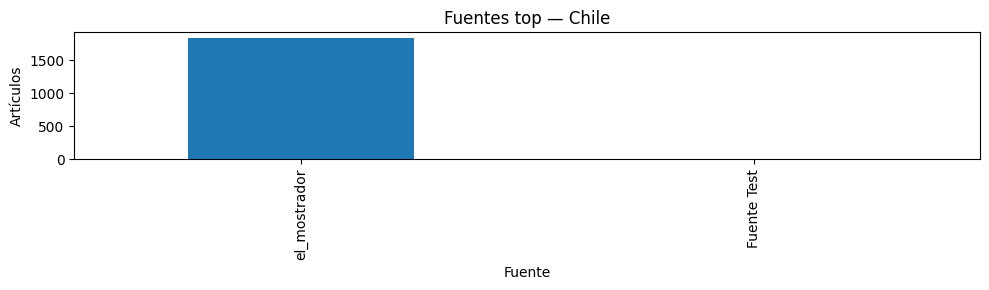

,entity,n
342,El Mostrador,377
277,Santiago,281
201,Estado,257
228,Estados Unidos,200
74,Gobierno,190
9,Gabriel Boric,184
13,Jeannette Jara,184
37,Argentina,166
7,Evelyn Matthei,163
221,América Latina,147


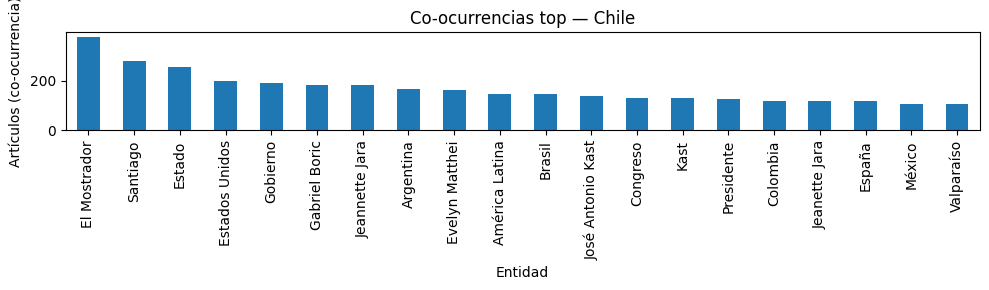

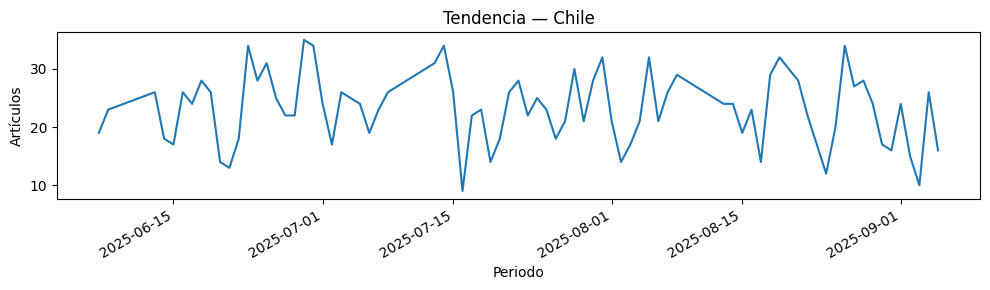


===== PERFIL: El Mostrador =====
Volumen (rows): 707  |  Cuota (share): 0.87%
Rango: 2025-06-07 00:00:00 → 2025-09-05 00:00:00
Polarity: avg=0.21923620933521923  |  %neg=18.2  %neu=41.6  %pos=40.2
Subjectivity: avg=0.071  p50=0.07  p75=0.081  p90=0.091  |  %≥0.36=0.0


,source,n
0,el_mostrador,707


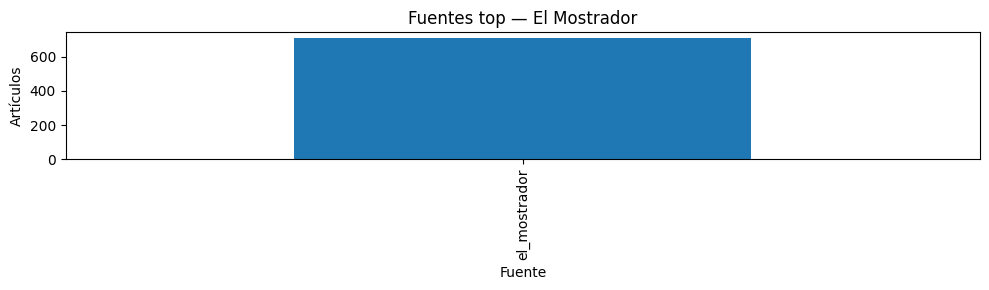

,entity,n
86,Chile,377
73,Santiago,121
299,Jeannette Jara,72
31,Inscríbete,72
82,Argentina,67
155,Estados Unidos,67
438,España,64
293,Evelyn Matthei,64
14,Gabriel Boric,63
316,Valparaíso,57


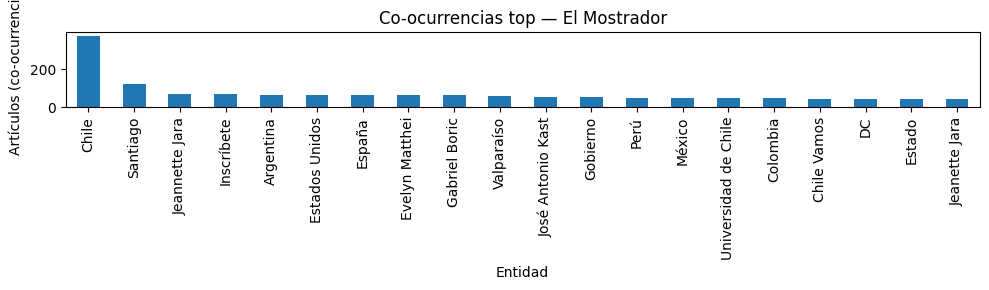

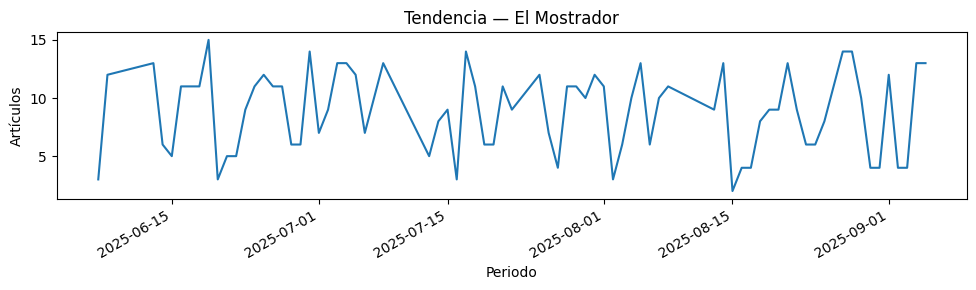


===== PERFIL: Santiago =====
Volumen (rows): 469  |  Cuota (share): 0.57%
Rango: 2025-06-07 00:00:00 → 2025-09-05 00:00:00
Polarity: avg=0.1279317697228145  |  %neg=22.6  %neu=42.0  %pos=35.4
Subjectivity: avg=0.073  p50=0.071  p75=0.084  p90=0.096  |  %≥0.36=0.0


,source,n
0,el_mostrador,469


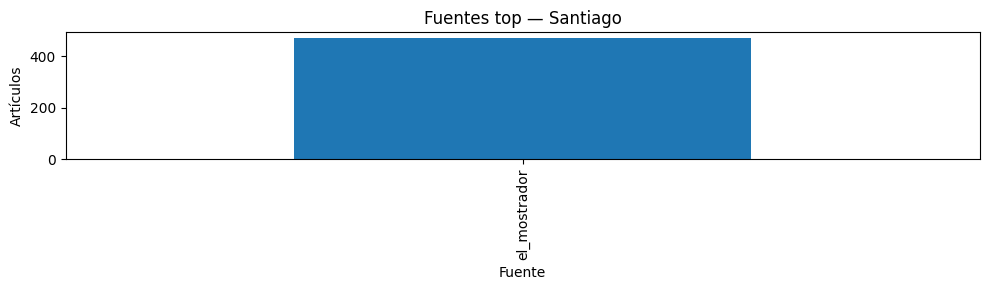

,entity,n
71,Chile,281
123,El Mostrador,121
61,Valparaíso,58
237,Gabriel Boric,49
476,Argentina,47
234,Estado,45
834,Ministerio Público,43
432,Brasil,43
239,Gobierno,42
442,Perú,40


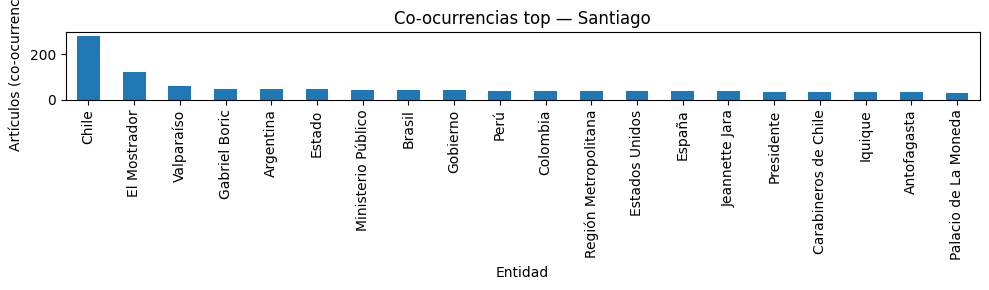

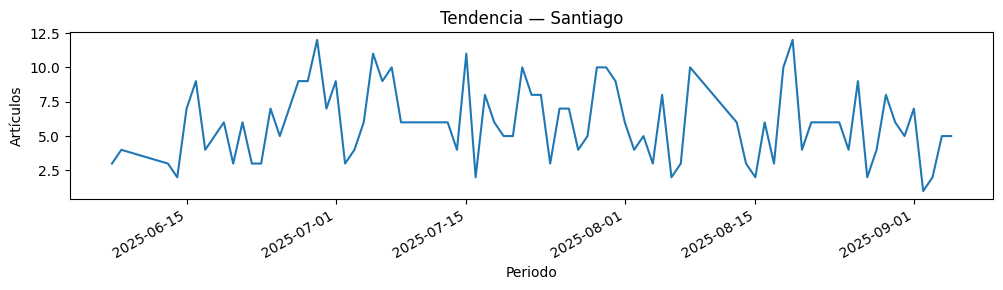


===== PERFIL: Estado =====
Volumen (rows): 487  |  Cuota (share): 0.6%
Rango: 2025-06-08 00:00:00 → 2025-09-05 00:00:00
Polarity: avg=-0.37782340862423  |  %neg=48.3  %neu=41.3  %pos=10.5
Subjectivity: avg=0.078  p50=0.077  p75=0.089  p90=0.102  |  %≥0.36=0.0


,source,n
0,el_mostrador,487


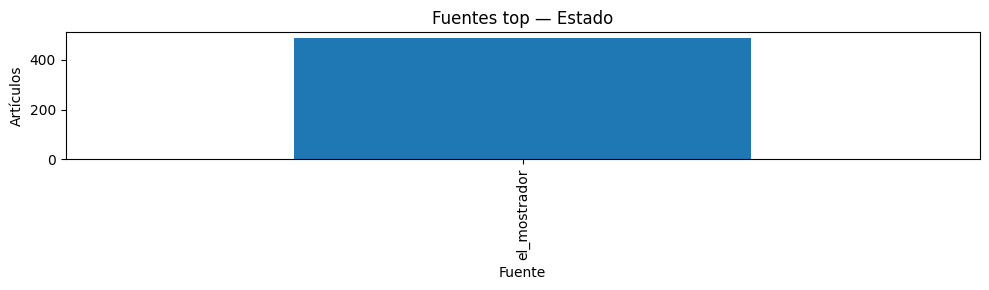

,entity,n
25,Chile,257
54,Gobierno,109
129,Gabriel Boric,68
206,Estados Unidos,60
182,Congreso,57
57,Kast,52
55,José Antonio Kast,51
51,Evelyn Matthei,50
191,Presidente,50
142,Santiago,45


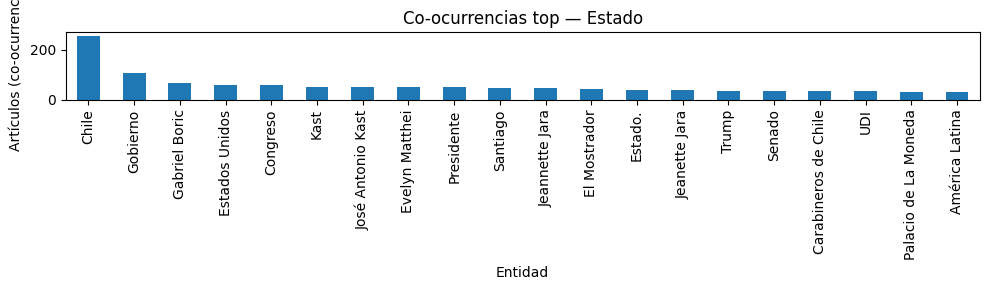

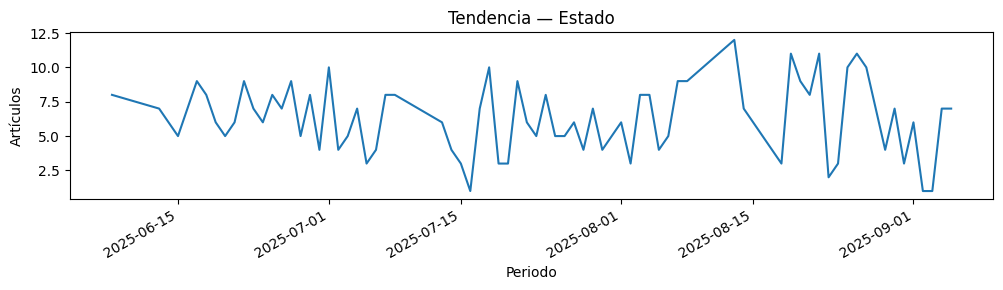


===== PERFIL: Estados Unidos =====
Volumen (rows): 443  |  Cuota (share): 0.54%
Rango: 2025-06-07 00:00:00 → 2025-09-05 00:00:00
Polarity: avg=-0.25733634311512416  |  %neg=41.1  %neu=43.6  %pos=15.3
Subjectivity: avg=0.079  p50=0.078  p75=0.089  p90=0.102  |  %≥0.36=0.0


,source,n
0,el_mostrador,443


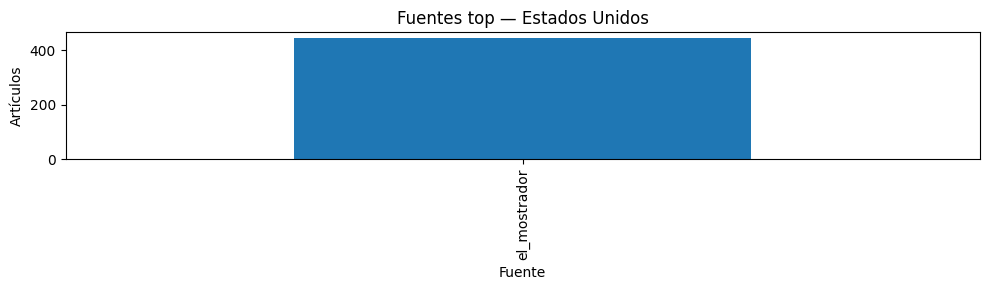

,entity,n
84,Chile,200
56,Donald Trump,190
75,Trump,171
172,EE.UU.,91
55,China,90
77,Washington,85
185,Israel,83
2272,Irán,78
110,Europa,70
49,Brasil,67


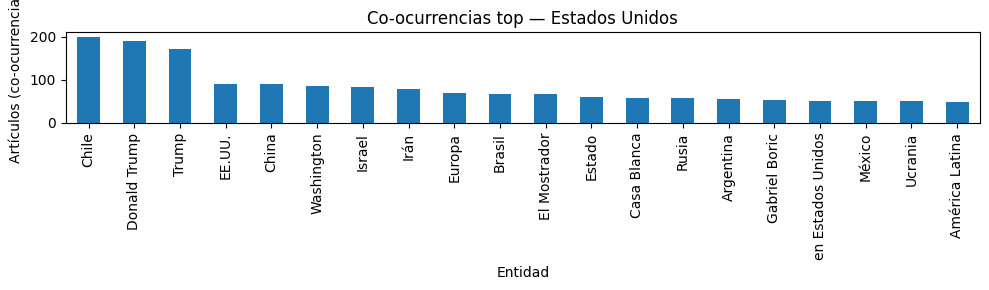

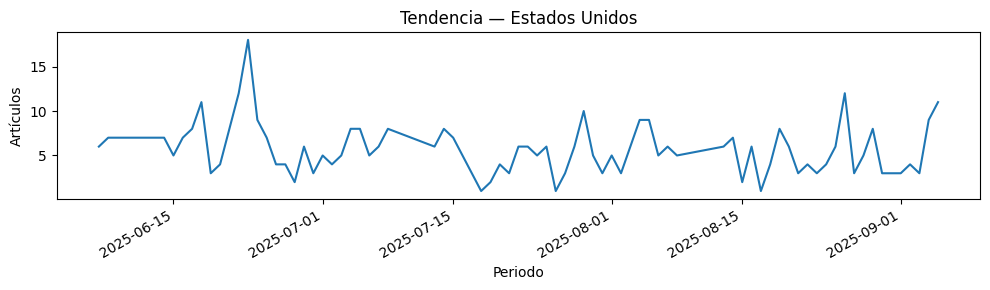

In [12]:
for prof in profiles:
    name = prof['name']
    print(f"\n===== PERFIL: {name} =====")
    print(f"Volumen (rows): {prof['rows']}  |  Cuota (share): {prof['share_pct']}%")
    print(f"Rango: {prof['first_date']} → {prof['last_date']}")
    print(f"Polarity: avg={prof['avg_polarity']}  |  %neg={prof['pct_neg']}  %neu={prof['pct_neu']}  %pos={prof['pct_pos']}")
    print(f"Subjectivity: avg={prof['avg_subjectivity']}  p50={prof['p50_subjectivity']}  p75={prof['p75_subjectivity']}  p90={prof['p90_subjectivity']}  |  %≥0.36={prof['pct_high_subjectivity']}")

    # Fuentes top (tabla)
    if not prof['sources'].empty:
        display(prof['sources'])
        ax = prof['sources'].set_index('source')['n'].plot(kind='bar', figsize=(10,3))
        ax.set_title(f'Fuentes top — {name}')
        ax.set_xlabel('Fuente')
        ax.set_ylabel('Artículos')
        plt.tight_layout()
        plt.show()

    # Co-ocurrencias (tabla + gráfico)
    if not prof['coocc'].empty:
        display(prof['coocc'].head(20))
        ax2 = prof['coocc'].head(20).set_index('entity')['n'].plot(kind='bar', figsize=(10,3))
        ax2.set_title(f'Co-ocurrencias top — {name}')
        ax2.set_xlabel('Entidad')
        ax2.set_ylabel('Artículos (co-ocurrencia)')
        plt.tight_layout()
        plt.show()

    # Trend (línea)
    if not prof['trend'].empty:
        ax3 = prof['trend'].set_index('period')['n'].plot(figsize=(10,3))
        ax3.set_title(f'Tendencia — {name}')
        ax3.set_xlabel('Periodo')
        ax3.set_ylabel('Artículos')
        plt.tight_layout()
        plt.show()